# ASSIGNMENT 1: Used Cars Price Prediction and Evaluation

<br>

### Table Of Contents:
1. [Data Cleaning](#clean)
2. [Data Visualisation](#visual)
    * [Companies. Their Models and Mean Selling Price.](#v1) 
    * [Popularity By Make/company](#v2)
    * [Popularity By Segment](#v3)
    * [Popularity By Colour](#v4)
    * [Popularity of Segment in Each Make](#v5)
    * [Fuel Type in Each Make](#v6)
    * [Price Variation](#v7)
    * [Price VS Make ](#v8)
    <br>
3. [Feature Selection](#featureSelection)
4. [Model](#model)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.stats.multicomp as multi

import warnings
warnings.filterwarnings('ignore')

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.set_option('display.max_rows',None)
sns.set_theme(style='darkgrid',font='fantasy')

In [3]:
df = pd.read_csv('cars_price.csv',index_col = 'Unnamed: 0')
df.head()

,make,model,priceUSD,year,condition,mileage(kilometers),fuel_type,volume(cm3),color,transmission,drive_unit,segment
0,honda,accord,565,1993,with mileage,960015.0,petrol,2000.0,black,mechanics,front-wheel drive,D
1,ford,fusion,5550,2008,with mileage,172000.0,diesel,1400.0,silver,mechanics,front-wheel drive,M
2,nissan,teana,8300,2008,with mileage,223000.0,petrol,2500.0,purple,auto,front-wheel drive,D
3,volkswagen,fox,3300,2005,with mileage,140000.0,petrol,1200.0,blue,mechanics,front-wheel drive,A
4,nissan,primera,2450,2002,with damage,413000.0,diesel,2200.0,burgundy,mechanics,front-wheel drive,D


The following columns need to be clearly understood:
* make : The brand of the car
* model: Model of the car
* priceUSD: Selling Price of the used car in US Dollars.
* year : Year in which the car was bought/launched.
* mileage(kilometers) : It actually refers to the total distance travelled by the car till now, and not the mileage. The column name is wrongly written.
* fuel_type: Either of petrol, diesel or electric.
* transmission: The type of transmission used by the car.(Automatic/Manual)
* volume(cm3) : Car engine displacement in cc.

In [4]:
df.describe()

,priceUSD,year,mileage(kilometers),volume(cm3)
count,40000.000000,40000.000000,4.000000e+04,39970.000000
mean,7430.383775,2003.485625,2.434332e+05,2103.201676
std,8338.242134,8.114896,3.167033e+05,938.724653
min,95.000000,1938.000000,0.000000e+00,500.000000
25%,2350.000000,1998.000000,1.370000e+05,1600.000000
50%,5350.000000,2004.000000,2.280000e+05,1995.000000
75%,9850.000000,2010.000000,3.087610e+05,2300.000000
max,195000.000000,2019.000000,9.999999e+06,20000.000000


In [5]:
df.isna().sum()

make                      0
model                     0
priceUSD                  0
year                      0
condition                 0
mileage(kilometers)       0
fuel_type                 0
volume(cm3)              30
color                     0
transmission              0
drive_unit             1345
segment                3755
dtype: int64

In [6]:
# sns.heatmap(df.corr(method='pearson'), annot=True,cmap="gist_yarg")

In [7]:
# sns.heatmap(df.corr(method='spearman'), annot=True,cmap="gist_yarg")

In [8]:
# sns.heatmap(df.corr(method='kendall'), annot=True,cmap="gist_yarg")

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   make                 40000 non-null  object 
 1   model                40000 non-null  object 
 2   priceUSD             40000 non-null  int64  
 3   year                 40000 non-null  int64  
 4   condition            40000 non-null  object 
 5   mileage(kilometers)  40000 non-null  float64
 6   fuel_type            40000 non-null  object 
 7   volume(cm3)          39970 non-null  float64
 8   color                40000 non-null  object 
 9   transmission         40000 non-null  object 
 10  drive_unit           38655 non-null  object 
 11  segment              36245 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 4.0+ MB


In [10]:
df.nunique()

make                     93
model                   991
priceUSD               2510
year                     72
condition                 3
mileage(kilometers)    6392
fuel_type                 3
volume(cm3)             396
color                    13
transmission              2
drive_unit                4
segment                   9
dtype: int64

In [11]:
# df.groupby(['make','model','segment']).first()

<br>

# DATA CLEANING <a class="anchor" id="clean"></a>

#### Detect and remove Outliers in Volume(cc)

From the general knowledge, it is clear that engine dispalcement (cc) of any car built till now is in between some hundred-cc to 6000cc or 7000cc.
Any engine displacement value beyond that can be treated as outlier. Such values in the data are extracted out and studied. 
I replaced these values with the median volume(cc) of the car of same model and make. 

<AxesSubplot:xlabel='volume(cm3)'>

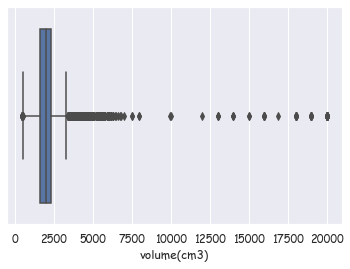

In [12]:
sns.set_context('notebook')
sns.boxplot(x=df['volume(cm3)'])

In [13]:
# sns.set_context('poster')
# sns.relplot(data=df,x='year',y='volume(cm3)',kind='scatter',height=6,aspect=1.5,hue='fuel_type',col='transmission')

In [14]:
c = df[df['volume(cm3)'] >= 7000].sort_values(by='volume(cm3)',ascending=True)
# c

In [15]:
new_df = df.drop(c.index)
for a, b in zip(c.iloc[:, 0], c.iloc[:, 1]):
    f = new_df[(new_df['make']==a) & (new_df['model']==b)]
    c.loc[(c['make']==a) & (c['model']==b), 'volume(cm3)'] = f['volume(cm3)'].median()
df = pd.concat([new_df,c],ignore_index=True)

In [16]:
df.shape

(40000, 12)

In [17]:
df[df['volume(cm3)'] >= 7000].sort_values(by='volume(cm3)',ascending=True)

,make,model,priceUSD,year,condition,mileage(kilometers),fuel_type,volume(cm3),color,transmission,drive_unit,segment


In [18]:
df.isna().sum()

make                      0
model                     0
priceUSD                  0
year                      0
condition                 0
mileage(kilometers)       0
fuel_type                 0
volume(cm3)              30
color                     0
transmission              0
drive_unit             1345
segment                3755
dtype: int64

In [19]:
df.shape

(40000, 12)

<br>

<br>

# DATA VISUALISATIONS <a class="anchor" id="visual"></a>

### Car companies. Their  Models and Mean Selling Price <a class="anchor" id="v1"></a>

In [20]:
# df1 = df.groupby(['make','model'])[['volume(cm3)','priceUSD']].agg([np.mean]).sort_values(['make',('volume(cm3)','mean')],ascending=[True,False])
# df1

<br>

### Popularity By Make <a class="anchor" id="v2"></a>

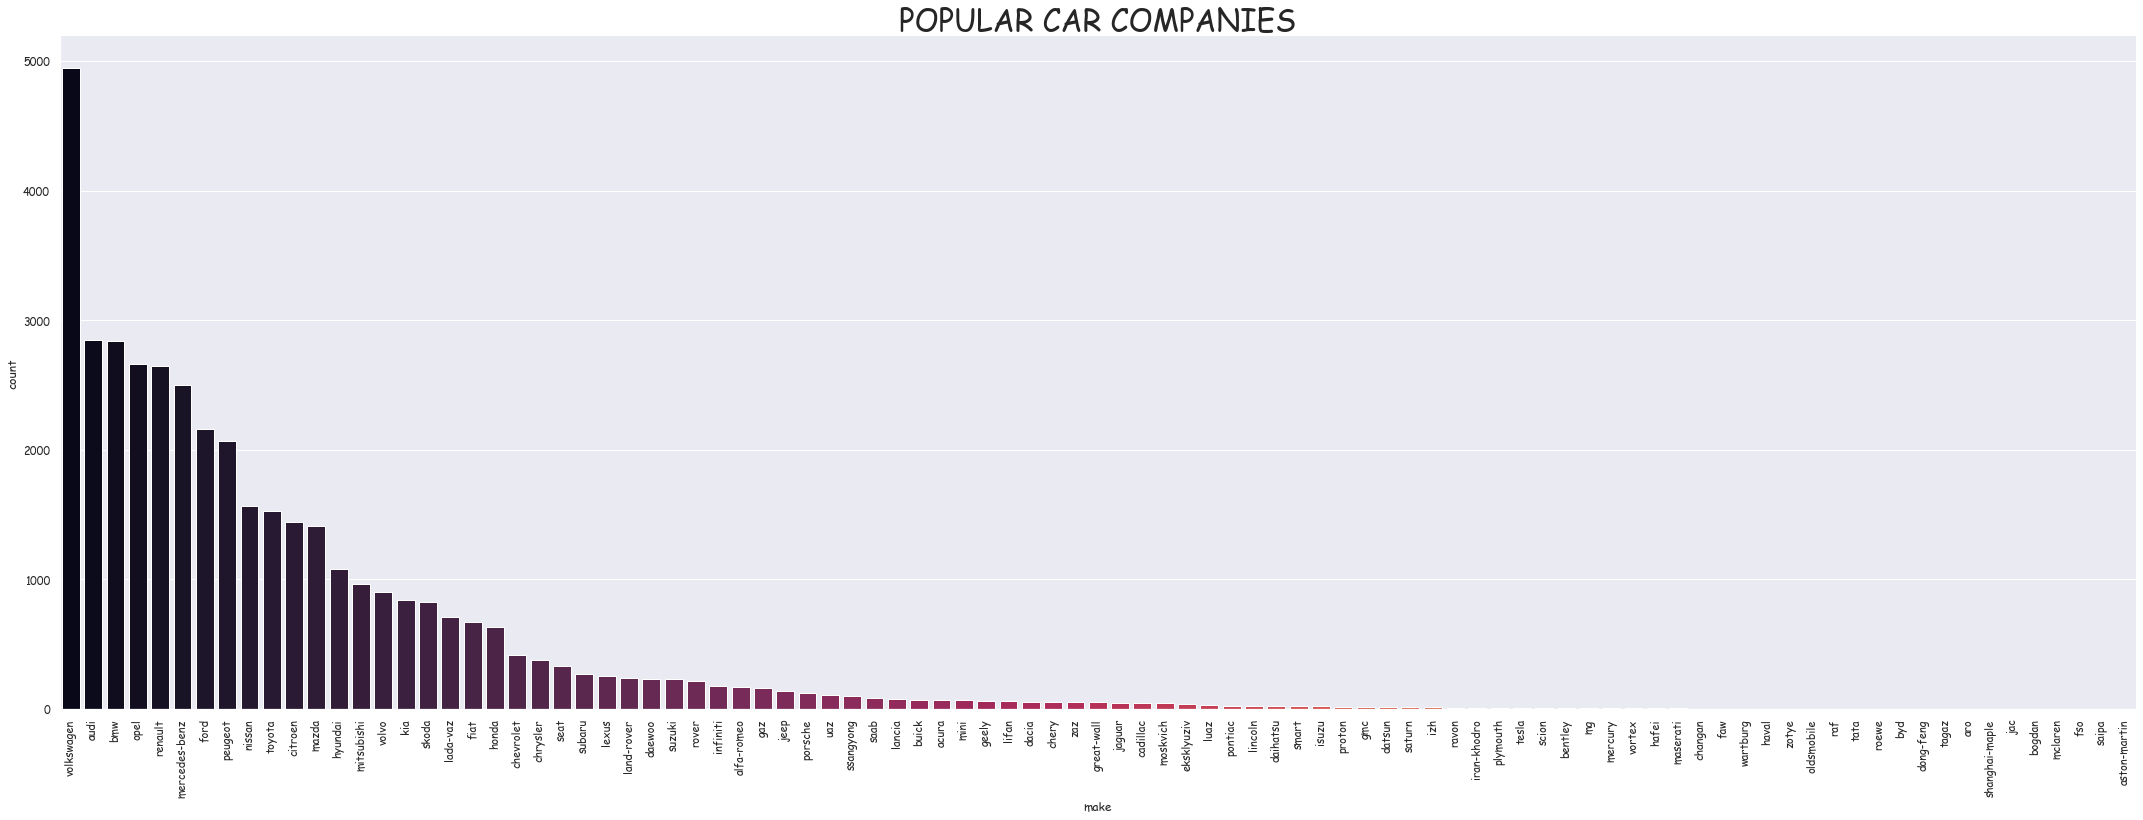

In [21]:
sns.catplot(data=df, x='make', kind="count", palette="rocket",height=10,aspect=3,order = df['make'].value_counts().index)
plt.title('POPULAR CAR COMPANIES',fontsize=30)
plt.xticks(rotation=90)
plt.show()

<br>

### Popularity By Segment<a class="anchor" id="v3"></a>

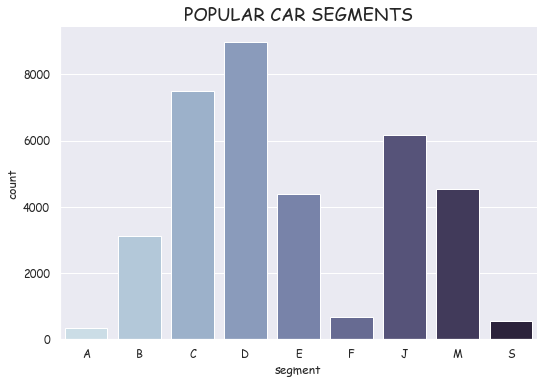

In [22]:
sns.set_context('notebook')
sns.catplot(data= df.sort_values('segment'), x='segment', kind="count", palette="ch:s=.25,rot=-.25",aspect=1.5)
plt.title('POPULAR CAR SEGMENTS',fontsize=18)
plt.show()

<br>

### Popularity By Color <a class="anchor" id="v4"></a> 

Text(0.5, 1.0, 'POPULAR CAR COLORS')

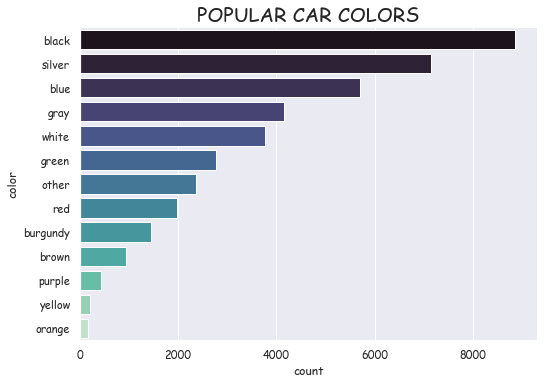

In [23]:
sns.set_context('notebook')
sns.catplot(y="color", data=df,kind='count',aspect=1.5,order=df.color.value_counts().index,palette='mako')
plt.title('POPULAR CAR COLORS',fontsize=20)

<br>

### Popularity By Segment in each Make<a class="anchor" id="v5"></a>

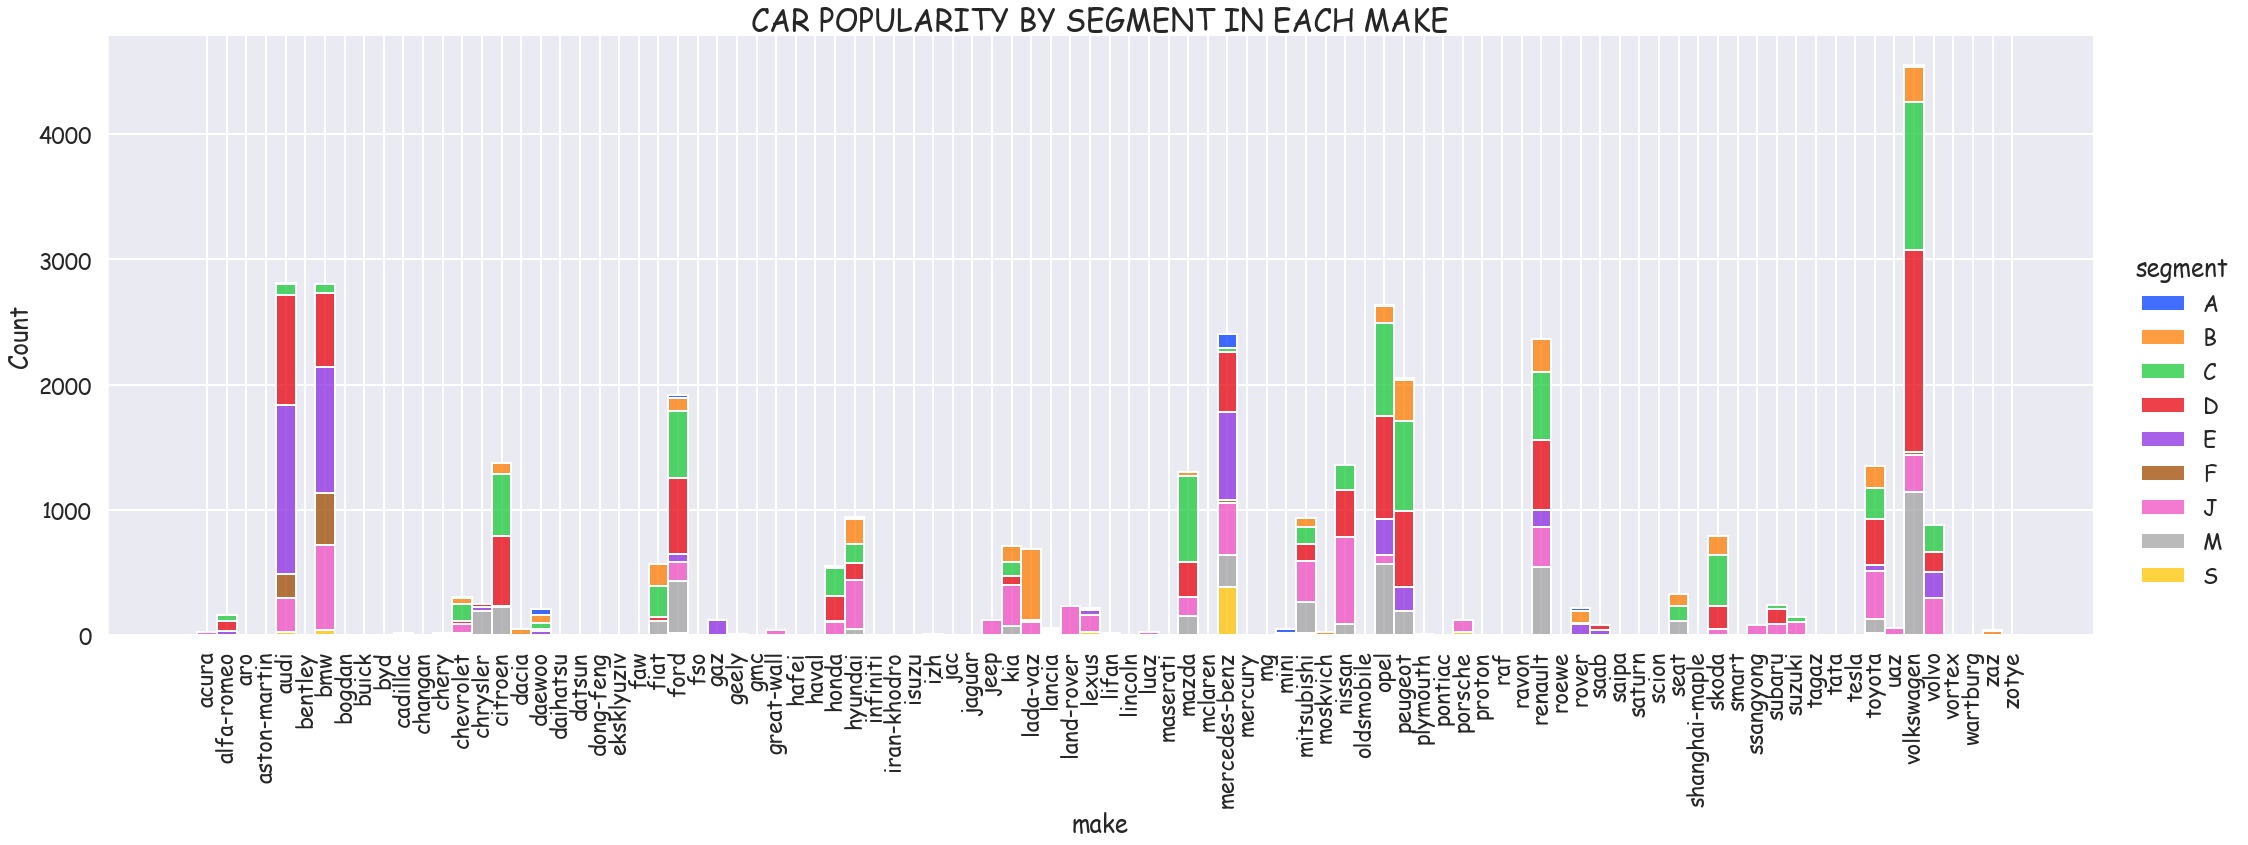

In [24]:
sns.set_context('poster')
sns.displot(df.sort_values('make'), x="make", hue="segment",hue_order= ['A','B','C','D','E','F','J','M','S'], multiple="stack",height=10,aspect=3,palette='bright')
plt.title('CAR POPULARITY BY SEGMENT IN EACH MAKE',fontsize=30)
plt.xticks(rotation=90)
plt.show()

<br>

### Popularity By Fuel Type in each Make<a class="anchor" id="v6"></a>

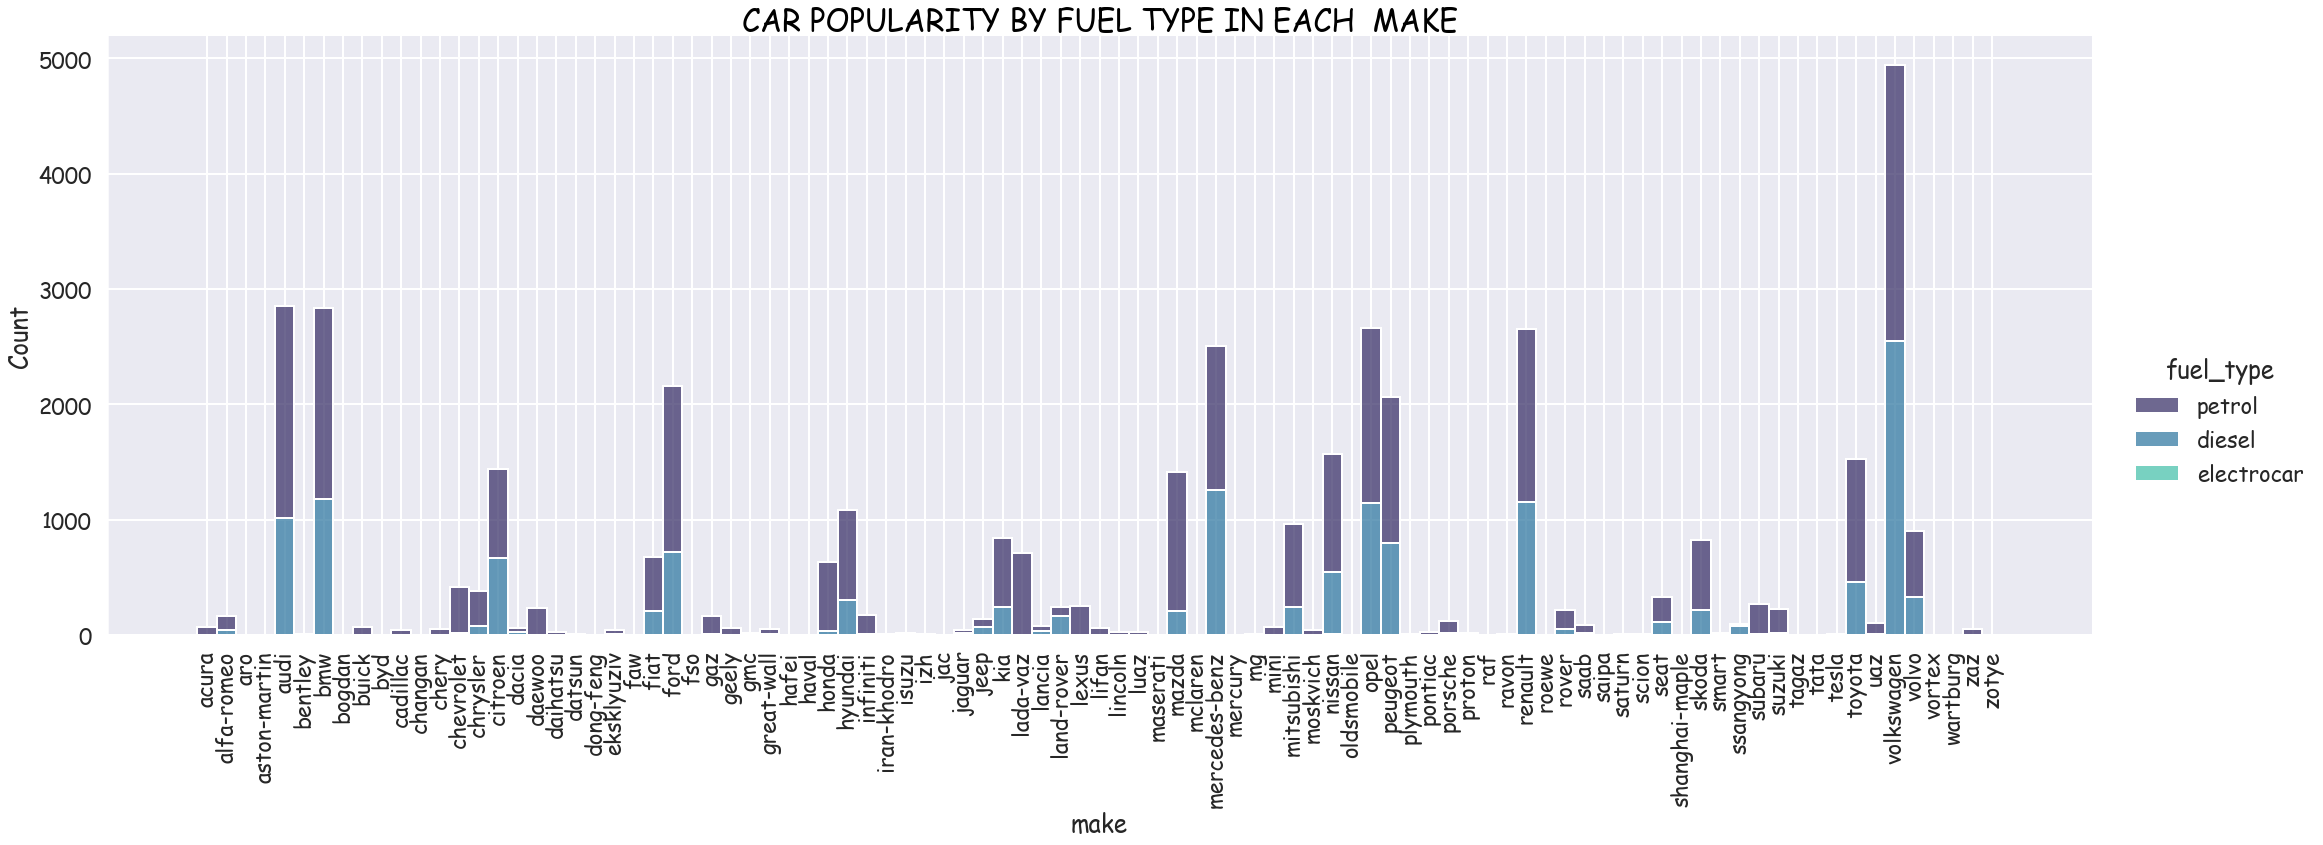

In [25]:
sns.displot(df.sort_values('make'), x="make", hue="fuel_type", multiple="stack",height=10,aspect=3,palette='mako')
plt.title('CAR POPULARITY BY FUEL TYPE IN EACH  MAKE',color='black',fontsize=30,fontweight=5)
plt.xticks(rotation=90)
plt.show()

<br>

###  Selling Price Variation<a class="anchor" id="v7"></a>

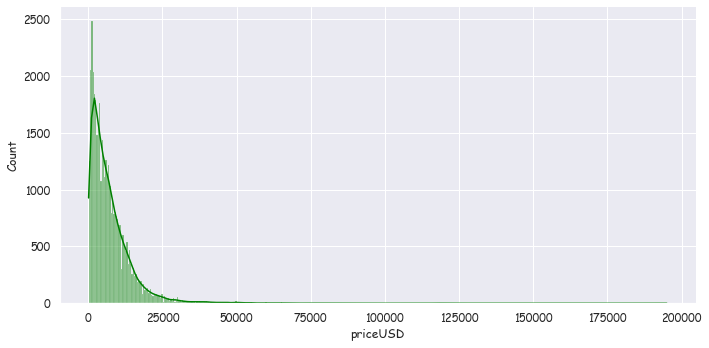

In [26]:
sns.set_context('notebook')
sns.displot(df,x='priceUSD',aspect=2,kind='hist',kde=True,color='green')

<br>

### Price Range of Each Make<a class="anchor" id="v8"></a>

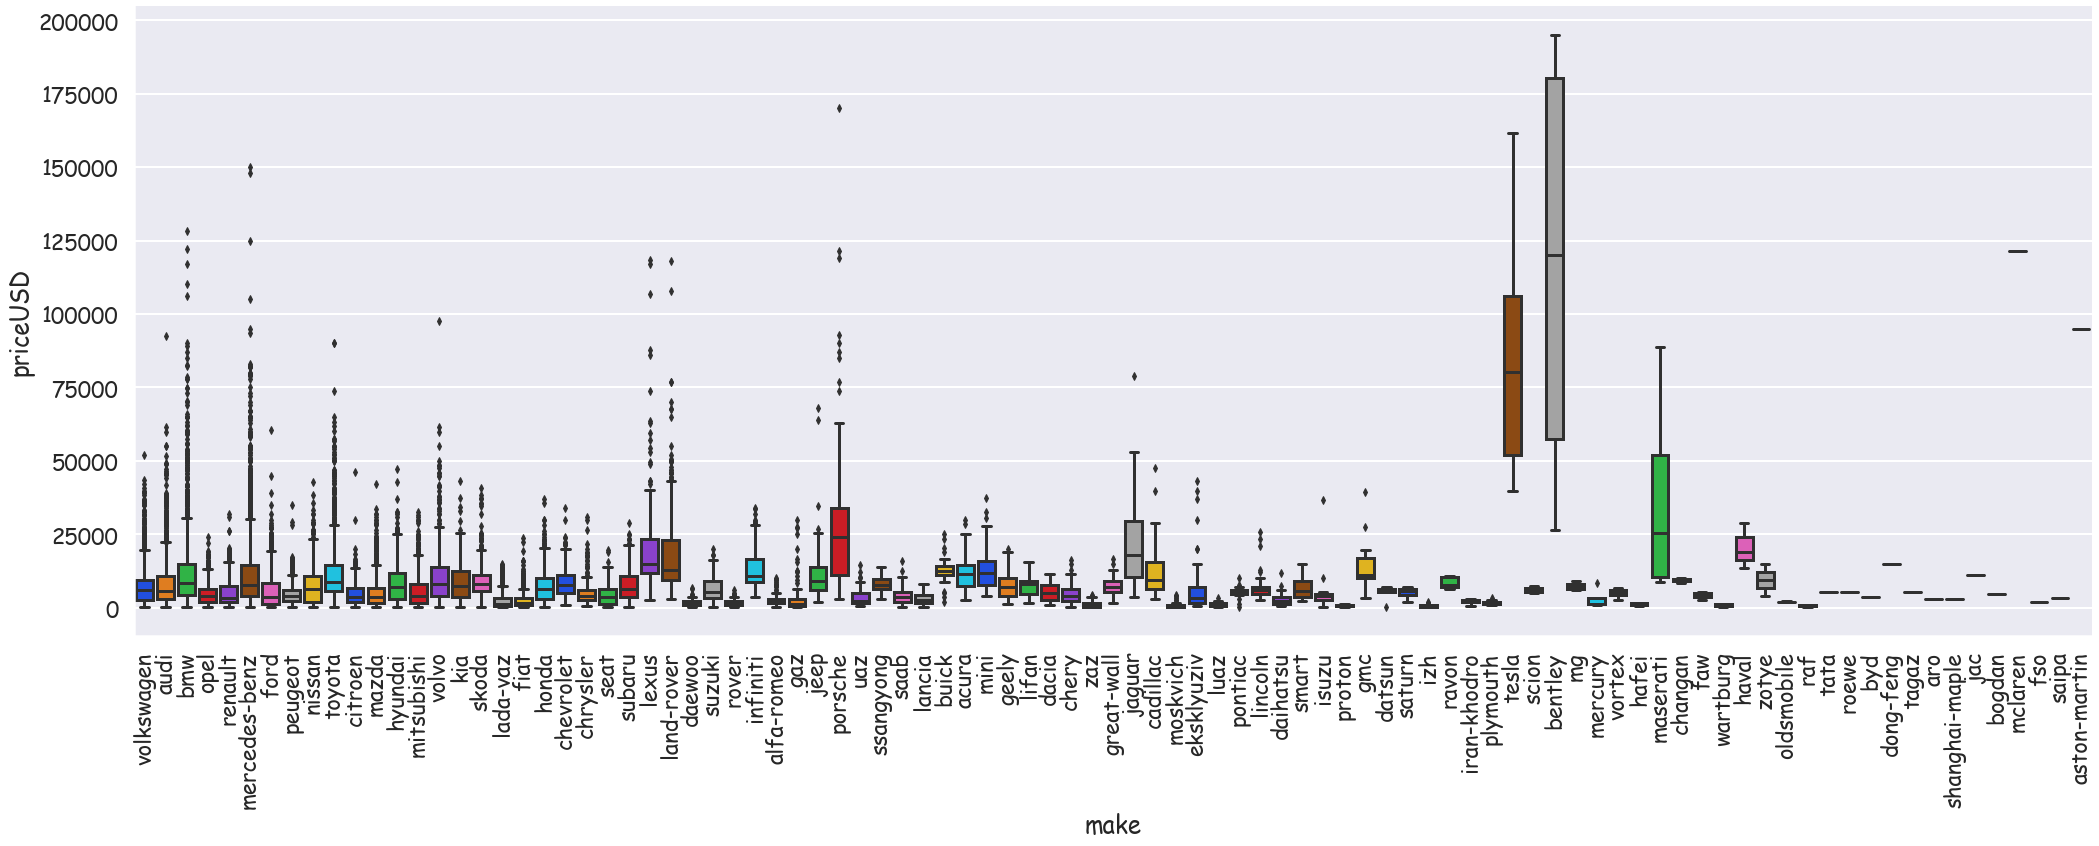

In [27]:
sns.set_context('poster')
sns.catplot(data=df,x='make',y='priceUSD',height=10,aspect=3,kind='box',order = df['make'].value_counts().index,palette='bright')
plt.xticks(rotation=90)
plt.show()

<br>

# FEATURE SELECTION <a class="anchor" id="featureSelection"></a> 

In [28]:
print(df.shape)
df.head()

(40000, 12)


,make,model,priceUSD,year,condition,mileage(kilometers),fuel_type,volume(cm3),color,transmission,drive_unit,segment
0,honda,accord,565,1993,with mileage,960015.0,petrol,2000.0,black,mechanics,front-wheel drive,D
1,ford,fusion,5550,2008,with mileage,172000.0,diesel,1400.0,silver,mechanics,front-wheel drive,M
2,nissan,teana,8300,2008,with mileage,223000.0,petrol,2500.0,purple,auto,front-wheel drive,D
3,volkswagen,fox,3300,2005,with mileage,140000.0,petrol,1200.0,blue,mechanics,front-wheel drive,A
4,nissan,primera,2450,2002,with damage,413000.0,diesel,2200.0,burgundy,mechanics,front-wheel drive,D


> #### NUMERICAL COLUMNS

I used heatmap to find the corelation between target('price of the car') and indivdual numerical features. This gave the most important numerical features to include in final model for better performance.  

In [29]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_regression
# fs = SelectKBest(score_func=f_regression,k=2)
# X_selected = fs.fit_transform(num_df,Y)
# X_selected

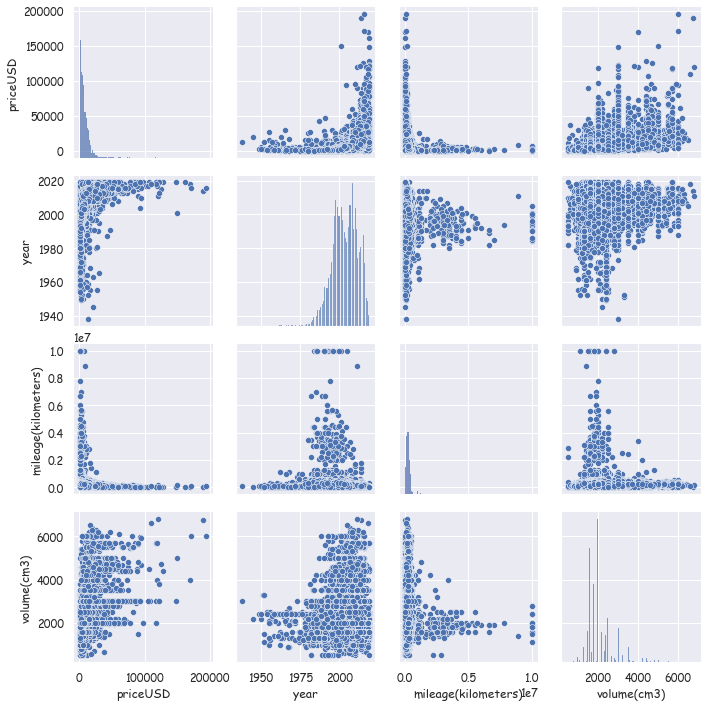

In [30]:
sns.set_context('notebook')
sns.pairplot(data=df,dropna=True)

* The pairplot is showing that the priceUSD is varying non-linearly with features (year,mileage and volume).
* So to find correlation matrix, 'spearman' method is used.

<AxesSubplot:>

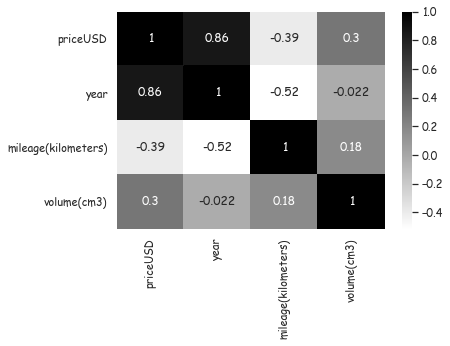

In [31]:
sns.heatmap(df.corr(method='spearman'), annot=True,cmap="gist_yarg")

The corr. heatmap gave expected results:
* Price of the car is more when it belongs to recent year. (corr. coef. = 0.86)
* Price of the car tends to get lower when it has already run a significant distance.(negative corr.)
* Cars with greater engine dispalcecment(volume) have more price. (corr coeff. = 0.37) <br><br>

Note that 'year' and 'mileage' of the cars have some sort of negative relation between them(-0.5)

In [32]:
df.drop(['mileage(kilometers)','volume(cm3)'],inplace=True,axis=1)

>>> Hence out of the three numereical features, only the YEAR feature is selected for model building.

> #### CATEGORICAL COLUMNS

In [33]:
df.head(2)

,make,model,priceUSD,year,condition,fuel_type,color,transmission,drive_unit,segment
0,honda,accord,565,1993,with mileage,petrol,black,mechanics,front-wheel drive,D
1,ford,fusion,5550,2008,with mileage,diesel,silver,mechanics,front-wheel drive,M


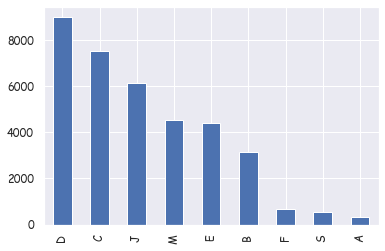

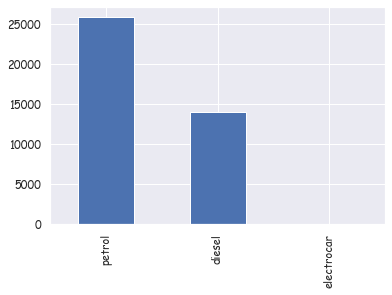

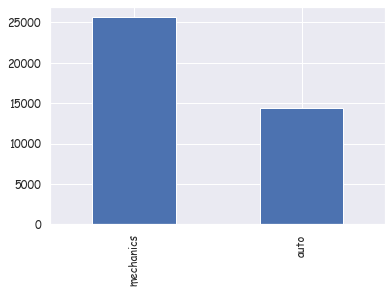

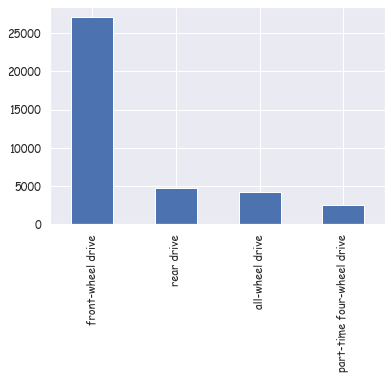

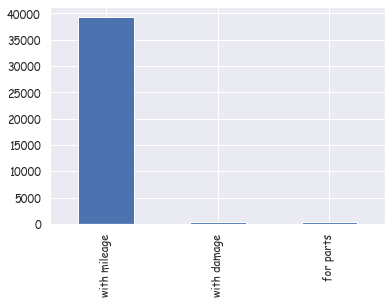

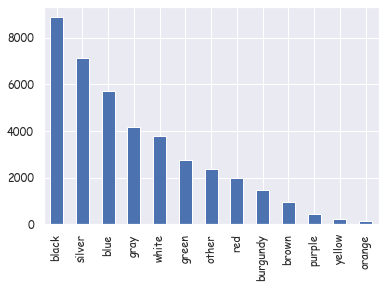

In [34]:
for i in ['segment','fuel_type','transmission','drive_unit','condition','color']:
    plt.figure()
    df[i].value_counts().plot(kind='bar')
    plt.show()

### Make, Model, Color, Condition, Drive_unit vary  with respect to number of samples in each group... So using them as relevant features in the model can give irrelevant results. So these features can be dropped.

<Figure size 432x288 with 0 Axes>

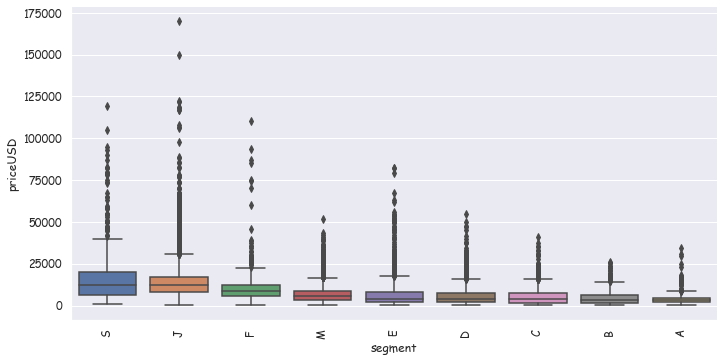

					 segment vs Price Of Car



<Figure size 432x288 with 0 Axes>

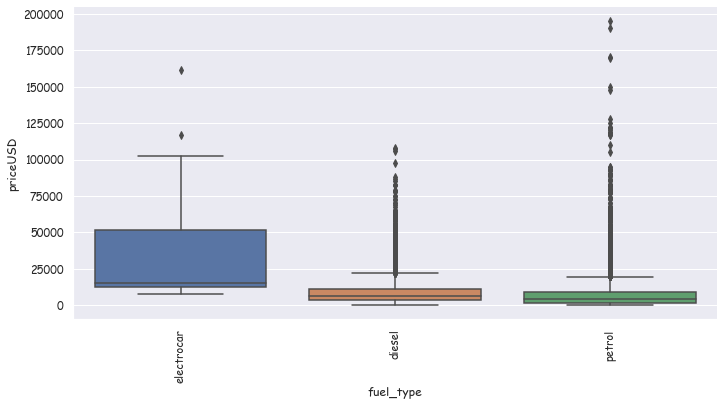

					 fuel_type vs Price Of Car



<Figure size 432x288 with 0 Axes>

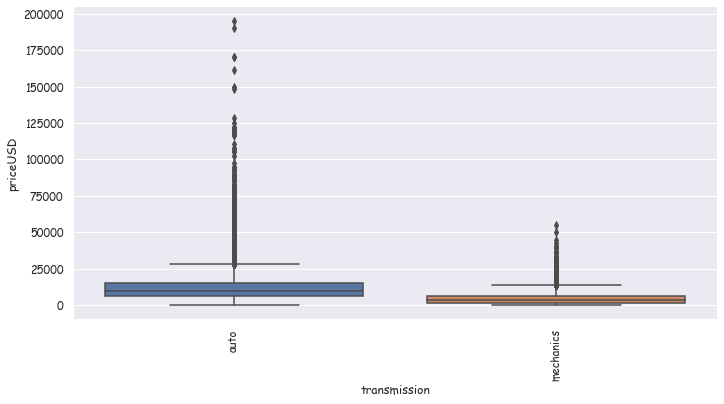

					 transmission vs Price Of Car



<Figure size 432x288 with 0 Axes>

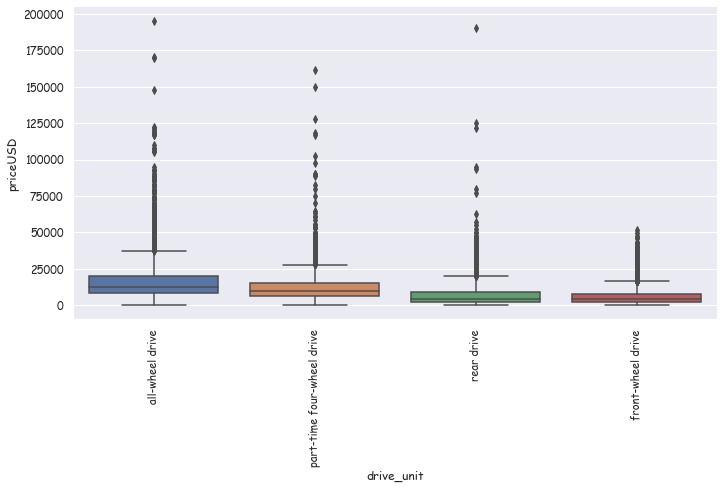

					 drive_unit vs Price Of Car



<Figure size 432x288 with 0 Axes>

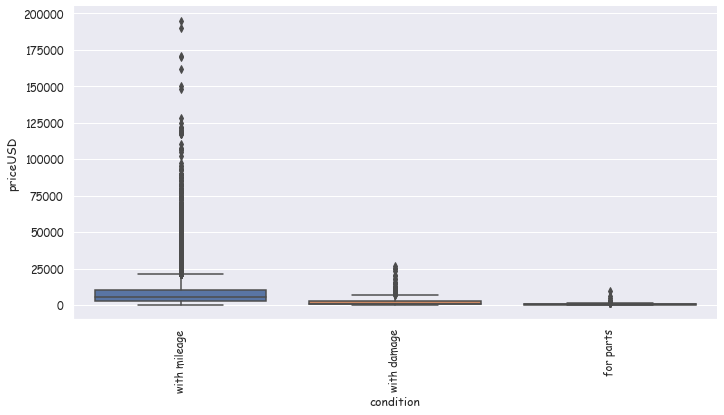

					 condition vs Price Of Car



<Figure size 432x288 with 0 Axes>

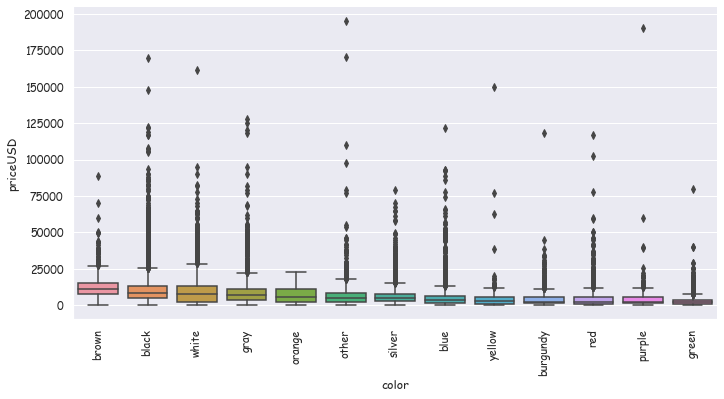

					 color vs Price Of Car



In [35]:
for i in ['segment','fuel_type','transmission','drive_unit','condition','color']:
    plt.figure()
    sns.catplot(data=df,x=i,y='priceUSD',height=5,aspect=2,kind='box',order=df.groupby([i])['priceUSD'].agg([np.median]).sort_values(by='median',ascending=False).index)
    plt.xticks(rotation=90)
    plt.show()
    print('\t\t\t\t\t',i,'vs Price Of Car\n')

In [36]:
df.drop(['segment','make','model','color','condition','drive_unit'],axis=1,inplace=True)

In [37]:
df.head(2)

,priceUSD,year,fuel_type,transmission
0,565,1993,petrol,mechanics
1,5550,2008,diesel,mechanics


In [38]:
df.shape

(40000, 4)

In [39]:
df.transmission.value_counts()

mechanics    25630
auto         14370
Name: transmission, dtype: int64

In [40]:
df.fuel_type.value_counts()

petrol        25869
diesel        14101
electrocar       30
Name: fuel_type, dtype: int64

In [41]:
df.drop(df[df['fuel_type']=='electrocar'].index,inplace=True)

In [42]:
# df.segment.replace(['A','B','C'],'ABC',inplace=True)

In [43]:
# df.segment.fillna('Z',inplace=True)

In [44]:
# df.drive_unit.fillna('other',inplace=True)

In [45]:
df.shape

(39970, 4)

In [46]:
df.fuel_type = df['fuel_type'].map({'petrol':0, 'diesel':1})
df.transmission = df['transmission'].map({'mechanics':0,'auto':1})
# df['segment']      = df['segment'].map({'ABC':0,'E':1,'M':2,'Z':3,'F':4,'J':5,'S':6})

In [47]:
df.head()

,priceUSD,year,fuel_type,transmission
0,565,1993,0,0
1,5550,2008,1,0
2,8300,2008,0,1
3,3300,2005,0,0
4,2450,2002,1,0


>> By STATSMODELS

In [48]:
mode = smf.ols('priceUSD ~ transmission + fuel_type',data=df).fit()
aov_table = anova_lm(mode,typ=2)

In [49]:
mcFuel = multi.MultiComparison(df['priceUSD'],df['fuel_type'])
resFuel = mcFuel.tukeyhsd()

mcTrans = multi.MultiComparison(df['priceUSD'],df['transmission'])
resTrans = mcTrans.tukeyhsd()

print('\t\t\tANOVA TABLE: \n\n',aov_table)
print('\n\n\tSUMMARY OF GROUP MEANS IN FUEL_TYPE:\n\n',resFuel.summary())
print('\n\n\tSUMMARY OF GROUP MEANS IN TRANSMISSION TYPE:\n\n',resTrans.summary())

			ANOVA TABLE: 

                     sum_sq       df             F         PR(>F)
transmission  5.871518e+11      1.0  11190.867125   0.000000e+00
fuel_type     6.072052e+10      1.0   1157.307668  4.361199e-250
Residual      2.096951e+12  39967.0           NaN            NaN


	SUMMARY OF GROUP MEANS IN FUEL_TYPE:

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj   lower     upper   reject
--------------------------------------------------------
     0      1 1758.2128 0.001 1590.0783 1926.3473   True
--------------------------------------------------------


	SUMMARY OF GROUP MEANS IN TRANSMISSION TYPE:

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj   lower     upper   reject
--------------------------------------------------------
     0      1 7766.2586 0.001 7616.0819 7916.4353   True
--------------------------------------------------------


**The p-value for both 'Fuel' and 'Transmission' features is below the significance level (0.05). So the features are significant and can be considered for model building.**

>> BY SCIPY STATS

In [50]:
# from scipy import stats
# def scipy_stats(i):
#     grps = pd.unique(categ_df[i].values)
#     d_data = {grp:df['priceUSD'][df[i] == grp] for grp in grps}
#     k = len(pd.unique(df[i]))
#     N = len(df.values)
#     n = df.groupby(i).size()[0]
#     return d_data

# i = 'fuel_type'
# d_data = scipy_stats(i)
# df[i].value_counts()

# stats.f_oneway(d_data['petrol'],d_data['diesel'])

<br>

In [51]:
df.reset_index(inplace=True,drop=True)

In [52]:
df.head()

,priceUSD,year,fuel_type,transmission
0,565,1993,0,0
1,5550,2008,1,0
2,8300,2008,0,1
3,3300,2005,0,0
4,2450,2002,1,0


In [53]:
scaler = MinMaxScaler()
df['year'] = scaler.fit_transform(df['year'].values.reshape(-1,1))

In [54]:
df.head()

,priceUSD,year,fuel_type,transmission
0,565,0.679012,0,0
1,5550,0.864198,1,0
2,8300,0.864198,0,1
3,3300,0.827160,0,0
4,2450,0.790123,1,0


<br>

# MODEL <a class="anchor" id="model"></a> 

In [55]:
x = df.drop('priceUSD',axis=1)
y = df['priceUSD']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4)
model = RandomForestRegressor()
model.fit(X_train,y_train)
pred = model.predict(X_test)

In [57]:
model.score(X_test,y_test)

0.6062853390190472

In [58]:
from sklearn.model_selection import cross_val_score
mod = RandomForestRegressor()
scores = cross_val_score(mod, x, y, cv=5)
scores

array([0.64632848, 0.63397296, 0.57469079, 0.5625992 , 0.58457545])

In [59]:
def find_best_model(X,y):
    algos={
#         'linear_regression':{
#             'model':LinearRegression(),
#             'params':{'normalize':[False,True]}
#                             },
        
        'decision_tree':{
            'model':DecisionTreeRegressor(),
            'params':{'criterion':['mse','friedman_mse'],'splitter':['best','random']}
                },
        
        'RandomForest':{
            'model':RandomForestRegressor(),
            'params':{'criterion':['mse'],'n_estimators':[50,100,200]}
              }
    }
    
    scores = []
    cv = ShuffleSplit(n_splits=5,test_size=0.2)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'],config['params'],cv=cv,return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model':algo_name,
            'best_score': gs.best_score_,
            'best_param':gs.best_params_
        })
    return pd.DataFrame(scores,columns=['model','best_score','best_param'])

In [60]:
find_best_model(x,y)   

,model,best_score,best_param
0,decision_tree,0.598642,"{'criterion': 'mse', 'splitter': 'best'}"
1,RandomForest,0.608760,"{'criterion': 'mse', 'n_estimators': 200}"
